In [2]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: ROICaT


In [717]:
import torch
import numpy as np
import tensorly as tl
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import sklearn.model_selection

import itertools

In [4]:
import sys
sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
%load_ext autoreload
%autoreload 2
from tensor_regression import multinomial_tensor_regression as mtr

import tensor_regression.util

In [6]:
labels = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Sabatini_lab/Kim/for Rich/session81/allLabels.mat', simplify_cells=True)['allLabels']
tensor = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Sabatini_lab/Kim/for Rich/session81/tensor.mat', simplify_cells=True)['tensor']
timepoints = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Sabatini_lab/Kim/for Rich/session81/timepoints_for_tensor.mat', simplify_cells=True)['timepoints_for_tensor']

In [7]:
print(f'Input data shapes:')
print(f'labels: {labels.shape}')
print(f'tensor: {tensor.shape}')
print(f'timepoints: {timepoints.shape}')

Input data shapes:
labels: (227,)
tensor: (8, 12, 227)
timepoints: (12,)


In [715]:
X = np.array(np.nan_to_num(tensor).transpose((2,0,1)), dtype=np.float32)
X = (X - np.mean(X, axis=1)[:,None,:])
y = np.array(labels, dtype=np.int64)

# y[y==1] = 0
# y[y>=2] = 1
# y[y==2] = 0
# y[y==3] = 1


DEVICE = tensor_regression.util.set_device(use_GPU=True)

u, c = np.unique(y, return_counts=True)
weights = c.sum() / c

hyperparameters = {}
hyperparameters['L2'] = [0.0, 0.001, 0.002, 0.004, 0.01, 0.02, 0.04]
hyperparameters['lr'] = [0.0003, 0.001, 0.003, 0.01, 0.03]
hyperparameters['rank'] = [1,2,3,4]
hyperparameters['Bcp_init_scale'] = [0.5, 1.0, 2.0]
hyperparameters['non_negative'] = [[False, False, False], [True, False, False], [False, True, False], [True, True, False]]
hyperparameters['iteration'] = list(np.arange(5))

results = {}
for ii, h_vals in enumerate(itertools.product(*hyperparameters.values())):
    h_dict = {key: hv for key, hv in zip(hyperparameters.keys(), h_vals)}
    print(f'hyperparameters: {h_dict}')

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

    cpmlr = mtr.CP_logistic_regression(
        X_train,
        y_train, 
        rank=h_dict['rank'],
        non_negative=h_dict['non_negative'],
        weights=None,
        Bcp_init=None,
        Bcp_init_scale=h_dict['Bcp_init_scale'],
        device=DEVICE,
        softplus_kwargs={
            'beta': 50,
            'threshold':1
        }
    )

    # cpmlr.fit(
    #     lambda_L2=0.000, 
    #     max_iter=200, 
    #     tol=1e-50, 
    #     patience=10,
    #     weights=weights,
    #     verbose=2,
    #     running_loss_logging_interval=1,
    #     LBFGS_kwargs={
    #         'lr' : 10000, 
    #         'max_iter' : 20, 
    #         'max_eval' : None, 
    #         'tolerance_grad' : 1e-07, 
    #         'tolerance_change' : 1e-09, 
    #         'history_size' : 100, 
    #         'line_search_fn' : "strong_wolfe"
    #     }
    #  )

    cpmlr.fit_Adam(
        lambda_L2=h_dict['L2'],
        max_iter=8000, 
        tol=1e-5, 
        patience=100,
        weights=weights,
        verbose=0,
        Adam_kwargs={
                'lr' : h_dict['lr'], 
    #                             'betas' : (0.9, 0.999), 
    #                             'eps' : 1e-08, 
    #                             'weight_decay' : 0, 
                'amsgrad' : True
            }
         )

    # # print(time.time() - tic)
    # print(f'loss: {cpmlr.loss_running[-1]}')

    # loss_all.append(cpmlr.loss_running[-1])

    logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
    cm = mtr.confusion_matrix(pred, y_test)
    acc_val = np.sum(np.diag(cm))/np.sum(cm)

    logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
    cm = mtr.confusion_matrix(pred, y_train)
    acc_train = np.sum(np.diag(cm))/np.sum(cm)
    print(f'Accuracy validation: {acc_val:.3f}, Accuracy train: {acc_train:.3f}')
    
    results[ii] = {}
    results[ii]['acc_val'] = acc_val
    results[ii]['acc_train'] = acc_train
    results[ii]['loss_running'] = cpmlr.loss_running
    results[ii]['loss_train_final'] = cpmlr.loss_running[-1]
    results[ii]['hyperparameters'] = h_dict


device: 'cuda'
hyperparameters: {'L2': 0.0, 'lr': 0.0003, 'rank': 1, 'Bcp_init_scale': 0.5, 'non_negative': [False, False, False], 'iteration': 0}
Accuracy validation: 0.23, Accuracy train: 0.37
hyperparameters: {'L2': 0.0, 'lr': 0.0003, 'rank': 1, 'Bcp_init_scale': 0.5, 'non_negative': [False, False, False], 'iteration': 1}
Accuracy validation: 0.27, Accuracy train: 0.42
hyperparameters: {'L2': 0.0, 'lr': 0.0003, 'rank': 1, 'Bcp_init_scale': 0.5, 'non_negative': [False, False, False], 'iteration': 2}
Accuracy validation: 0.23, Accuracy train: 0.32
hyperparameters: {'L2': 0.0, 'lr': 0.0003, 'rank': 1, 'Bcp_init_scale': 0.5, 'non_negative': [False, False, False], 'iteration': 3}
Accuracy validation: 0.38, Accuracy train: 0.40
hyperparameters: {'L2': 0.0, 'lr': 0.0003, 'rank': 1, 'Bcp_init_scale': 0.5, 'non_negative': [False, False, False], 'iteration': 4}


KeyboardInterrupt: 

Accuracy TRAIN: 0.6640285204991088


<IPython.core.display.Javascript object>


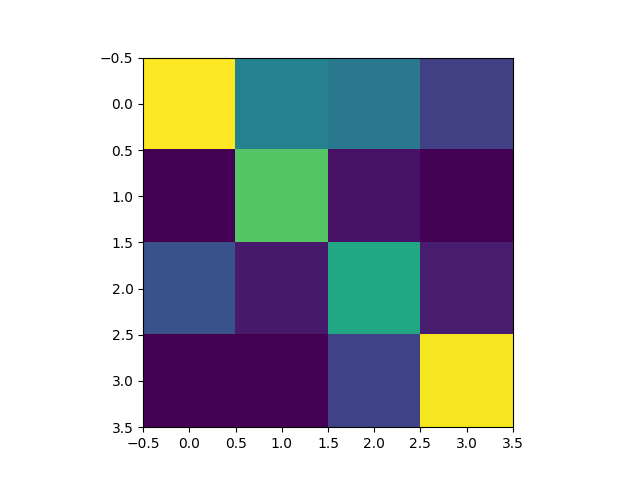

In [688]:
logit, pred = cpmlr.predict(X=X_train, y_true=y_train)
cm = mtr.confusion_matrix(pred, y_train)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TRAIN: {acc}')

plt.figure()
plt.imshow(cm)

Accuracy TEST: 0.34882352941176464


<IPython.core.display.Javascript object>


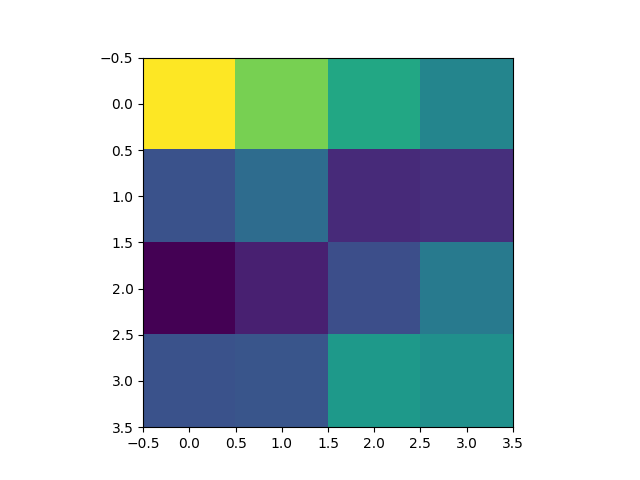

In [689]:
logit, pred = cpmlr.predict(X=X_test, y_true=y_test)
cm = mtr.confusion_matrix(pred, y_test)
acc = np.sum(np.diag(cm))/np.sum(cm)

print(f'Accuracy TEST: {acc}')

plt.figure()
plt.imshow(cm)

In [679]:
X.shape

(227, 8, 12)

<IPython.core.display.Javascript object>


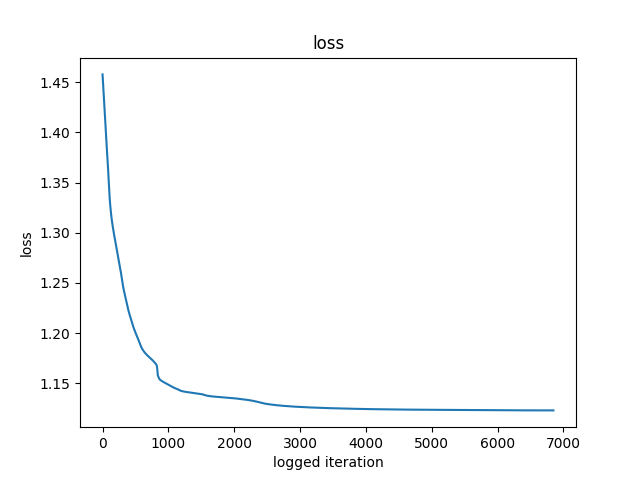

<IPython.core.display.Javascript object>


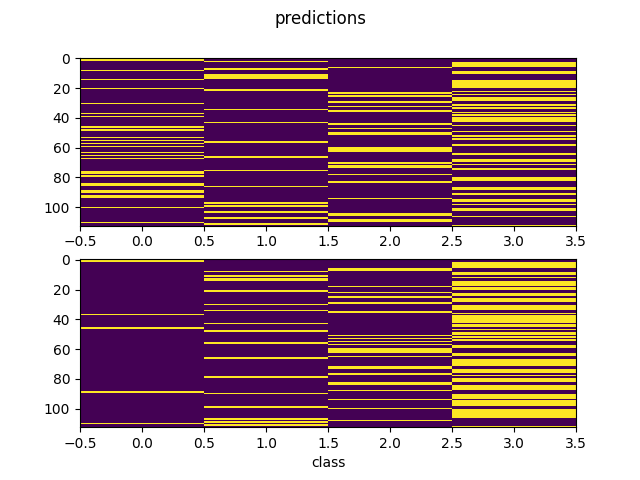

<IPython.core.display.Javascript object>


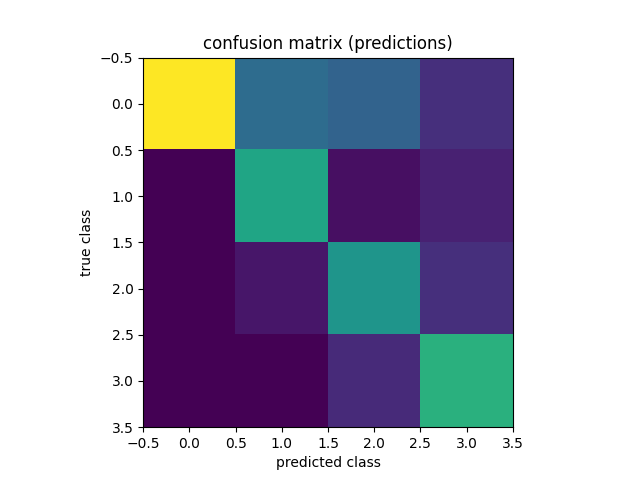

<IPython.core.display.Javascript object>


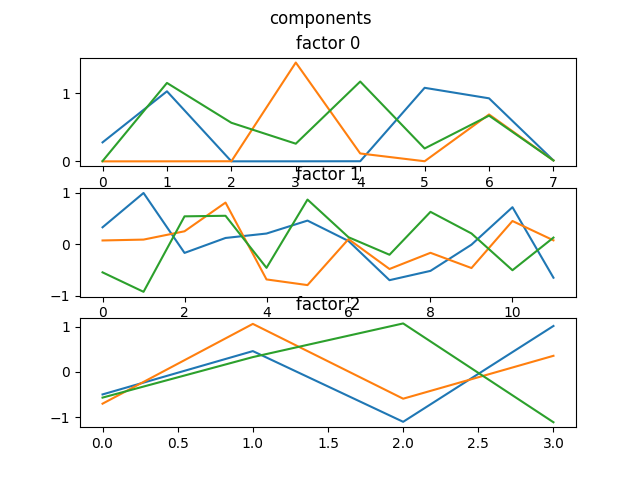

In [680]:
cpmlr.plot_outputs()

In [614]:
cpmlr.make_confusion_matrix()

(array([[0.8       , 0.23529412, 0.36      , 0.25757576],
        [0.        , 0.76470588, 0.32      , 0.28787879],
        [0.        , 0.        , 0.        , 0.        ],
        [0.2       , 0.        , 0.32      , 0.45454545]]),
 0.504812834224599)